In [1]:
# ✅ Install required packages (usually already available in Colab)
!pip install -q matplotlib scipy numpy



Title: Reconstructing High-Resolution Time Series with Radial Basis Function Interpolation (RBFI)

In many real-world datasets—especially those involving environmental sensors, tides, or even marketing data—
data arrives in irregular intervals: hourly, every 5 minutes, or even daily. Missing values are also common.
This creates a central challenge: how do we reconstruct a complete, high-resolution time series from
fragmented and inconsistent inputs?

As an applied mathematician, I explored Radial Basis Function Interpolation (RBFI) as a solution to this
problem. RBFI is a method for scattered data interpolation that uses kernel-based functions—like Gaussian,
Multiquadric, or Thin Plate—centered at known data points to smoothly estimate values in between.

Why RBFI is powerful:
- Kernels can be customized to match the nature of your signal.
- Sliding windows make the interpolation adaptive and localized.
- Its infinite-dimensional function space captures both high-frequency and low-frequency behavior, making it ideal
  for reconstructing complex signals like tides or sensor data.

Research Setup:
- Real-world tidal height data with varying granularities and injected missing values
- Tested several kernel types: Gaussian, Multiquadric, Thin Plate, and custom (e.g. Cauchy)
- Sliding windows applied with multiple N-point neighborhoods
- Evaluated with RMSE, Log-MSE, and a composite score: RMSE × (-Log-MSE)

Key Finding:
Even with 10% or 25% of the data missing, the Multiquadric kernel with a sliding window of ~30 points
reconstructed the 5-minute signal with high accuracy. And all of this is achieved without any training phase—
this is a pure interpolation method, driven entirely by math.

Why this matters:
- Predictive modeling: Improves input quality by filling gaps
- Visualization: Produces smooth and interpretable plots
- Feature engineering: Enhances time-aware machine learning pipelines
- Real-time monitoring: Ensures continuity even during sensor dropouts

RBFI is not just a mathematical curiosity—it’s a trusted tool across fields like geophysics, fluid dynamics,
computer graphics, and machine learning. Its ability to handle noisy, irregular, or missing data makes it
indispensable in time series reconstruction.




# Inicial Testing with generated Data and different Kernels

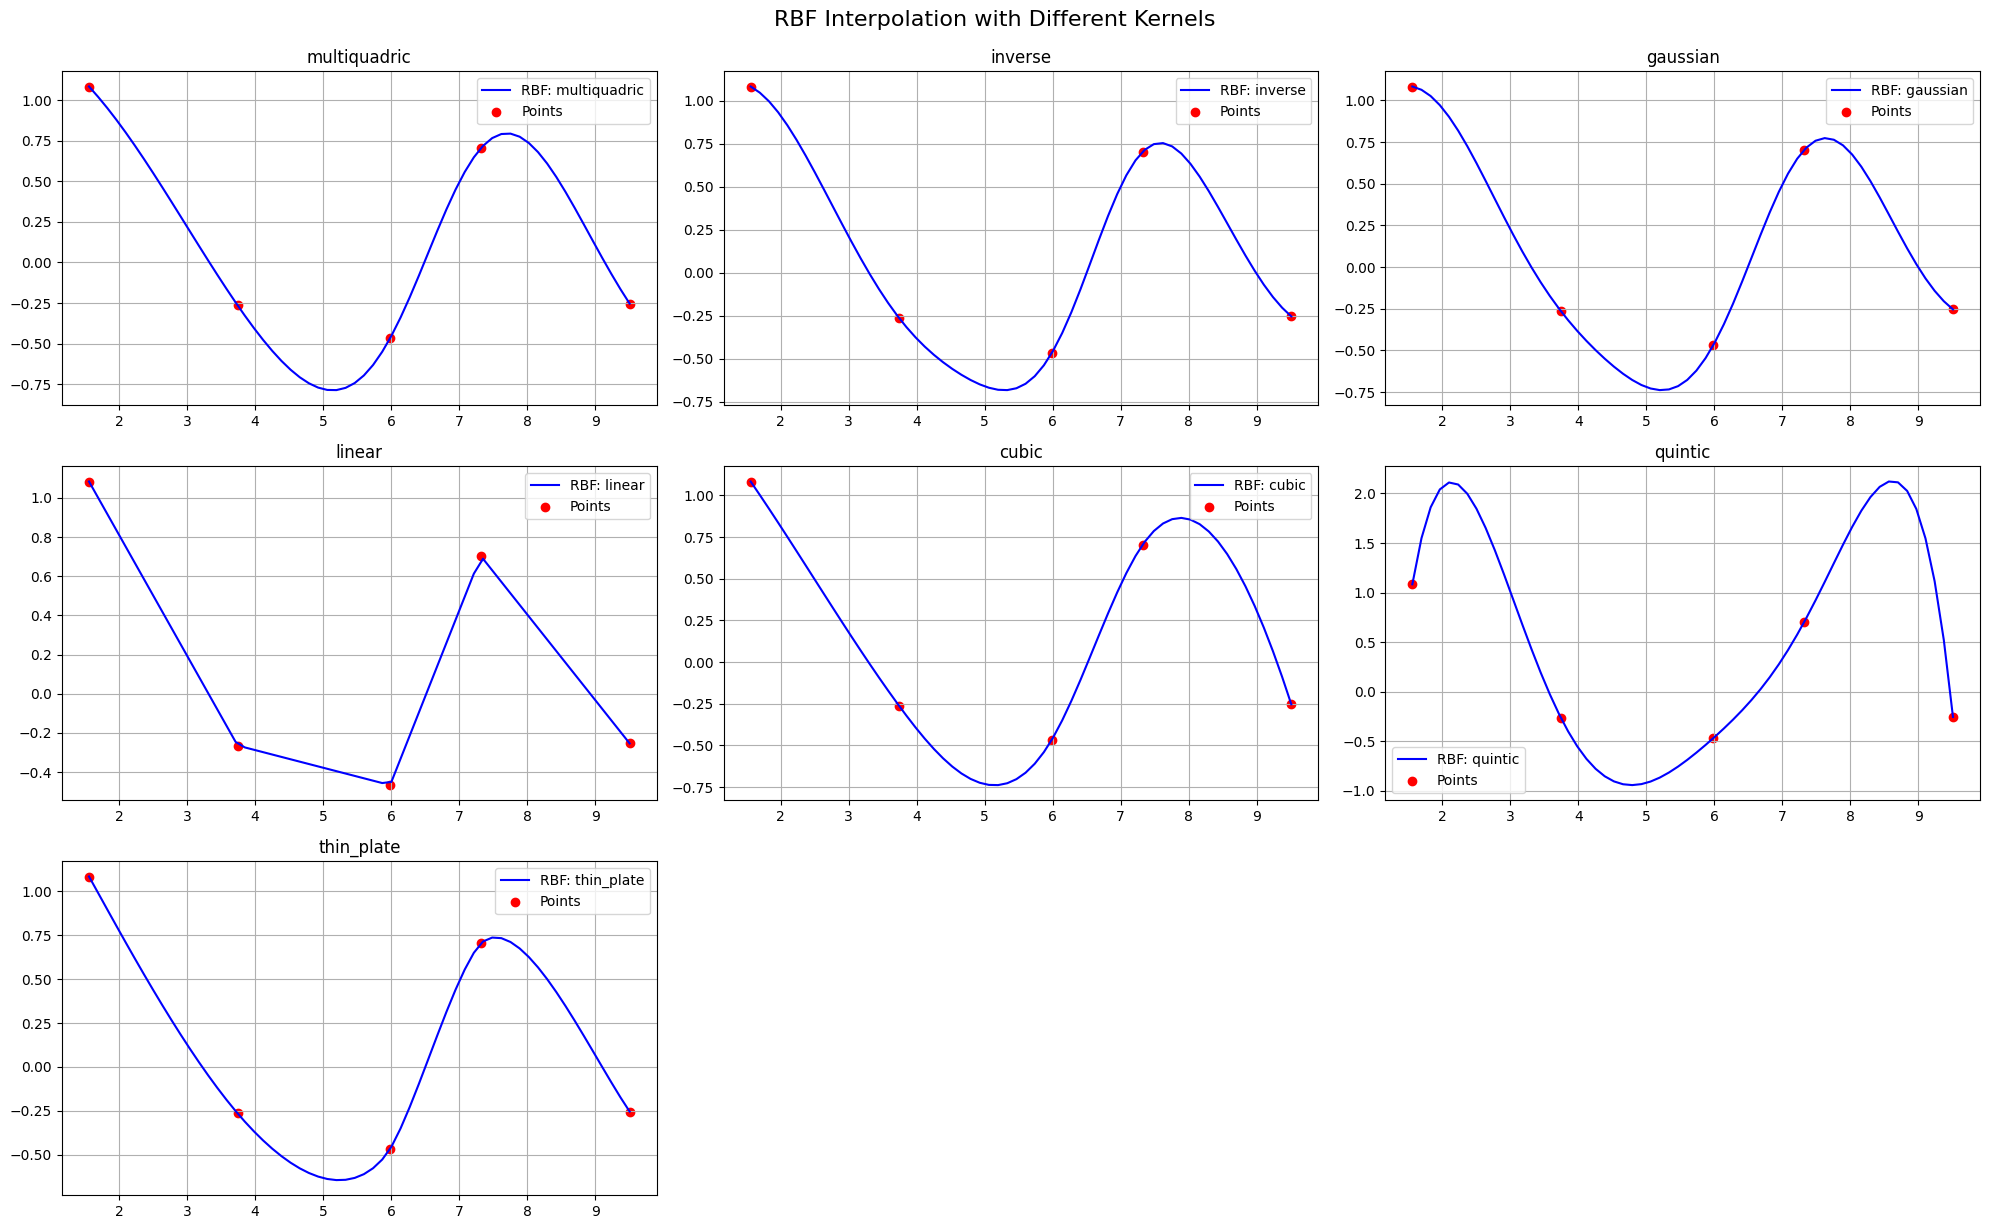

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# Random seed for reproducibility
np.random.seed(42)

# Generate N random points
N = 5
x = np.sort(np.random.rand(N) * 10)
y = np.sin(x) + 0.3 * np.random.randn(N)

# RBF kernel types to try
rbf_kernels = ['multiquadric', 'inverse', 'gaussian', 'linear', 'cubic', 'quintic', 'thin_plate']

# Prepare smoother x values for interpolation curve
x_smooth = np.linspace(min(x), max(x), 12*N)

# Setup the plot
plt.figure(figsize=(20, 12))
for i, kernel in enumerate(rbf_kernels, start=1):
    # Apply RBF interpolation
    rbf = Rbf(x, y, function=kernel)
    y_smooth = rbf(x_smooth)

    # Subplot
    plt.subplot(3, 3, i)
    plt.plot(x_smooth, y_smooth, label=f'RBF: {kernel}', color='blue')
    plt.scatter(x, y, color='red', label='Points')
    plt.title(kernel)
    plt.grid(True)
    plt.legend()

# Adjust layout and show
plt.tight_layout()
plt.suptitle('RBF Interpolation with Different Kernels', fontsize=16, y=1.02)
plt.show()
#thin_plate, multiquadric e gaussian

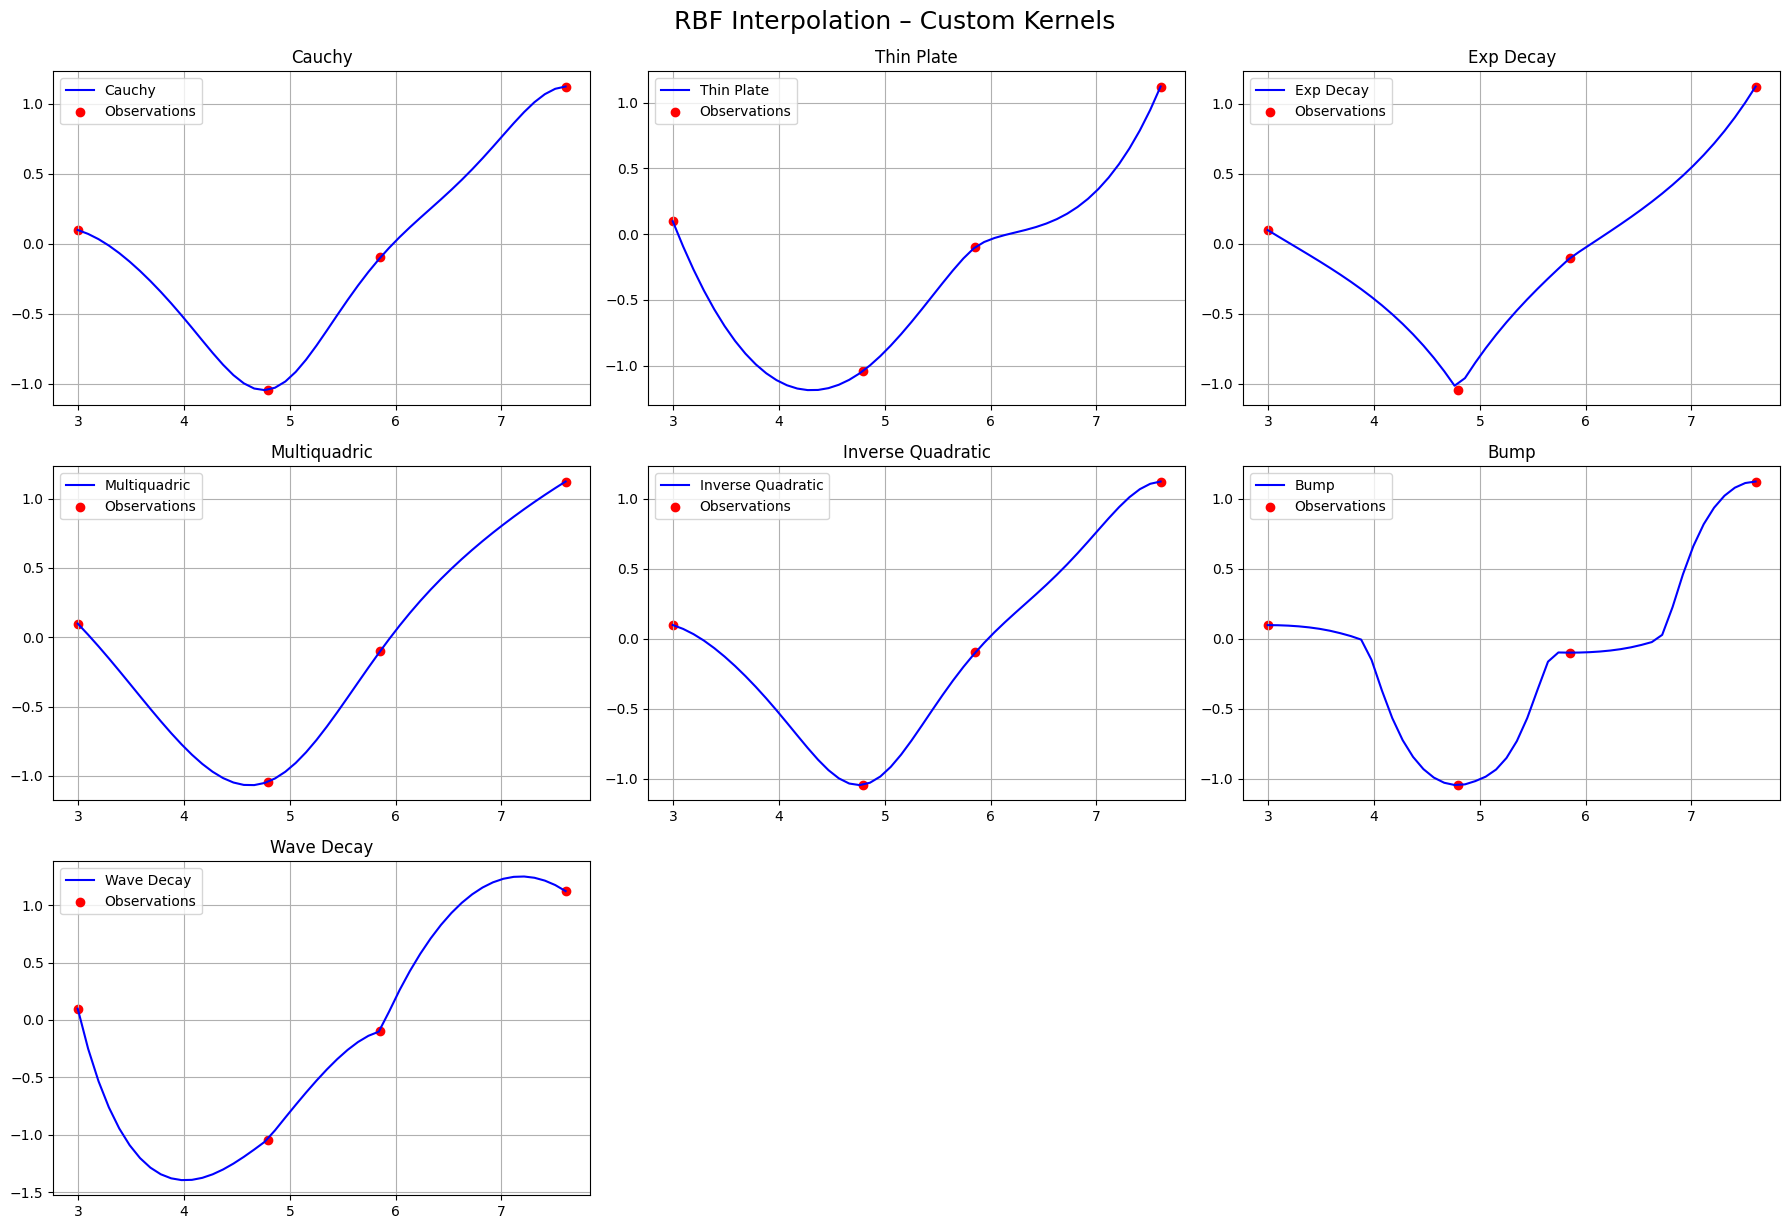

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# ===============================
# Define all custom kernel functions
custom_kernels = {
    'Cauchy': lambda r: 1.0 / (1.0 + r**2),
    'Thin Plate': lambda r: (r**2) * np.log(r + 1e-6),
    'Exp Decay': lambda r: np.exp(-r),
    'Multiquadric': lambda r: np.sqrt(1 + r**2),
    'Inverse Quadratic': lambda r: 1 / (1 + r**2),
    'Bump': lambda r: np.where(r < 1, np.exp(-1 / (1 - r**2)), 0),
    'Wave Decay': lambda r: np.sin(r) / (1 + r),
}

# ===============================
# Simulated hourly data (N points)
np.random.seed(42)
N = 4
x = np.sort(np.random.rand(N) * 8)         # Hours
y = np.sin(x) + 0.2 * np.random.randn(N)    # Simulated tide height

# ===============================
# Fine-grained time to simulate 5-minute intervals (~12 per hour)
x_smooth = np.linspace(min(x), max(x), N * 12)

# ===============================
# Plot setup
n_kernels = len(custom_kernels)
cols = 3
rows = (n_kernels + cols - 1) // cols
plt.figure(figsize=(6 * cols, 4 * rows))

for i, (name, kernel_func) in enumerate(custom_kernels.items(), 1):
    try:
        rbf = Rbf(x, y, function=kernel_func)
        y_smooth = rbf(x_smooth)

        plt.subplot(rows, cols, i)
        plt.plot(x_smooth, y_smooth, label=name, color='blue')
        plt.scatter(x, y, color='red', label='Observations')
        plt.title(name)
        plt.grid(True)
        plt.legend()
    except Exception as e:
        print(f"Kernel '{name}' failed: {e}")

plt.tight_layout()
plt.suptitle("RBF Interpolation – Custom Kernels", fontsize=18, y=1.02)
plt.show()


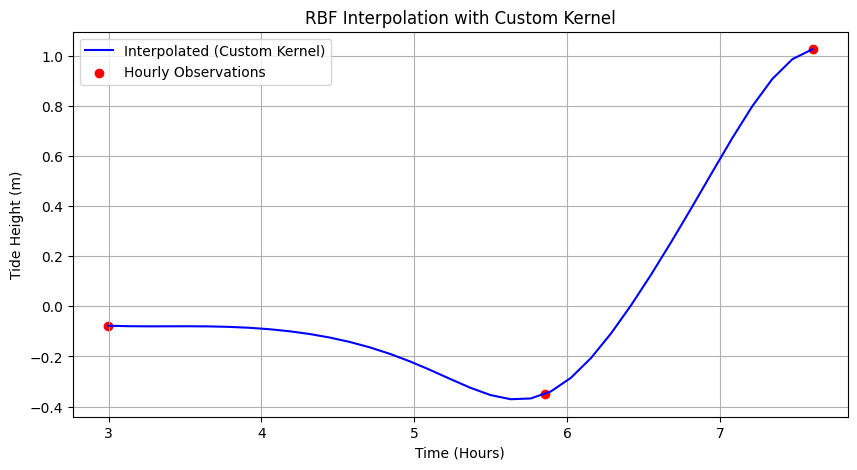

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# ===============================
# 👇 Define your custom RBF kernel
# Cauchy Kernel
def custom_kernel(r):
    return 1.0 / (1.0 + r**2)


# ===============================
# Simulated hourly data (N points)
np.random.seed(42)
N = 3
x = np.sort(np.random.rand(N) * 8)         # Hours
y = np.sin(x) + 0.2 * np.random.randn(N)     # Simulated tide height

# ===============================
# Fine-grained time to simulate 5-minute intervals (~12 per hour)
x_smooth = np.linspace(min(x), max(x), N * 12)

# ===============================
# Use custom kernel in RBF interpolator
rbf = Rbf(x, y, function=custom_kernel)
y_smooth = rbf(x_smooth)

# ===============================
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_smooth, y_smooth, label='Interpolated (Custom Kernel)', color='blue')
plt.scatter(x, y, color='red', label='Hourly Observations')
plt.title('RBF Interpolation with Custom Kernel')
plt.xlabel('Time (Hours)')
plt.ylabel('Tide Height (m)')
plt.grid(True)
plt.legend()
plt.show()


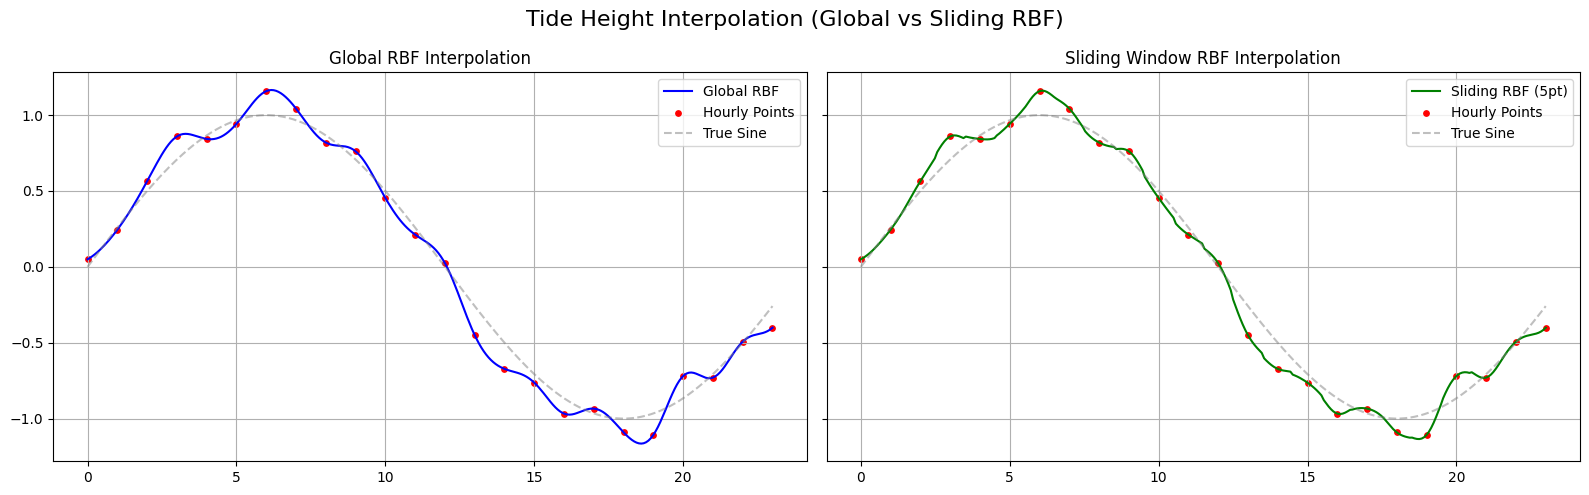

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from scipy.ndimage import gaussian_filter1d

# ===============================
# Simulate hourly tide data
np.random.seed(42)
x_hourly = np.arange(24)  # 24 hours
y_hourly = np.sin(x_hourly * 2 * np.pi / 24) + 0.1 * np.random.randn(24)  # Tidal cycle + noise

# ===============================
# Create 5-minute intervals (12x more points)
x_dense = np.linspace(x_hourly.min(), x_hourly.max(), len(x_hourly)*12)
y_dense_true = np.sin(x_dense * 2 * np.pi / 24)  # True function (for visual reference)

# ===============================
# Method 1: Global RBF
rbf_global = Rbf(x_hourly, y_hourly, function='gaussian')
y_global = rbf_global(x_dense)

# ===============================
# Method 2: Sliding Window RBF (5-point window)
def rbf_sliding_interpolation(x_known, y_known, x_interp, window=6):
    y_out = np.zeros_like(x_interp)
    half = window // 2

    for i, xi in enumerate(x_interp):
        # Find closest indices in x_known
        idx = np.argsort(np.abs(x_known - xi))[:window]
        x_win = x_known[idx]
        y_win = y_known[idx]
        try:
            rbf_local = Rbf(x_win, y_win, function='gaussian')
            y_out[i] = rbf_local(xi)
        except:
            y_out[i] = np.nan  # fallback if local RBF fails

    return y_out

y_sliding = rbf_sliding_interpolation(x_hourly, y_hourly, x_dense, window=5)

# ===============================
# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

axs[0].plot(x_dense, y_global, label='Global RBF', color='blue')
axs[0].scatter(x_hourly, y_hourly, color='red', s=15, label='Hourly Points')
axs[0].plot(x_dense, y_dense_true, '--', color='gray', alpha=0.5, label='True Sine')
axs[0].set_title('Global RBF Interpolation')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(x_dense, y_sliding, label='Sliding RBF (5pt)', color='green')
axs[1].scatter(x_hourly, y_hourly, color='red', s=15, label='Hourly Points')
axs[1].plot(x_dense, y_dense_true, '--', color='gray', alpha=0.5, label='True Sine')
axs[1].set_title('Sliding Window RBF Interpolation')
axs[1].legend()
axs[1].grid(True)

plt.suptitle('Tide Height Interpolation (Global vs Sliding RBF)', fontsize=16)
plt.tight_layout()
plt.show()


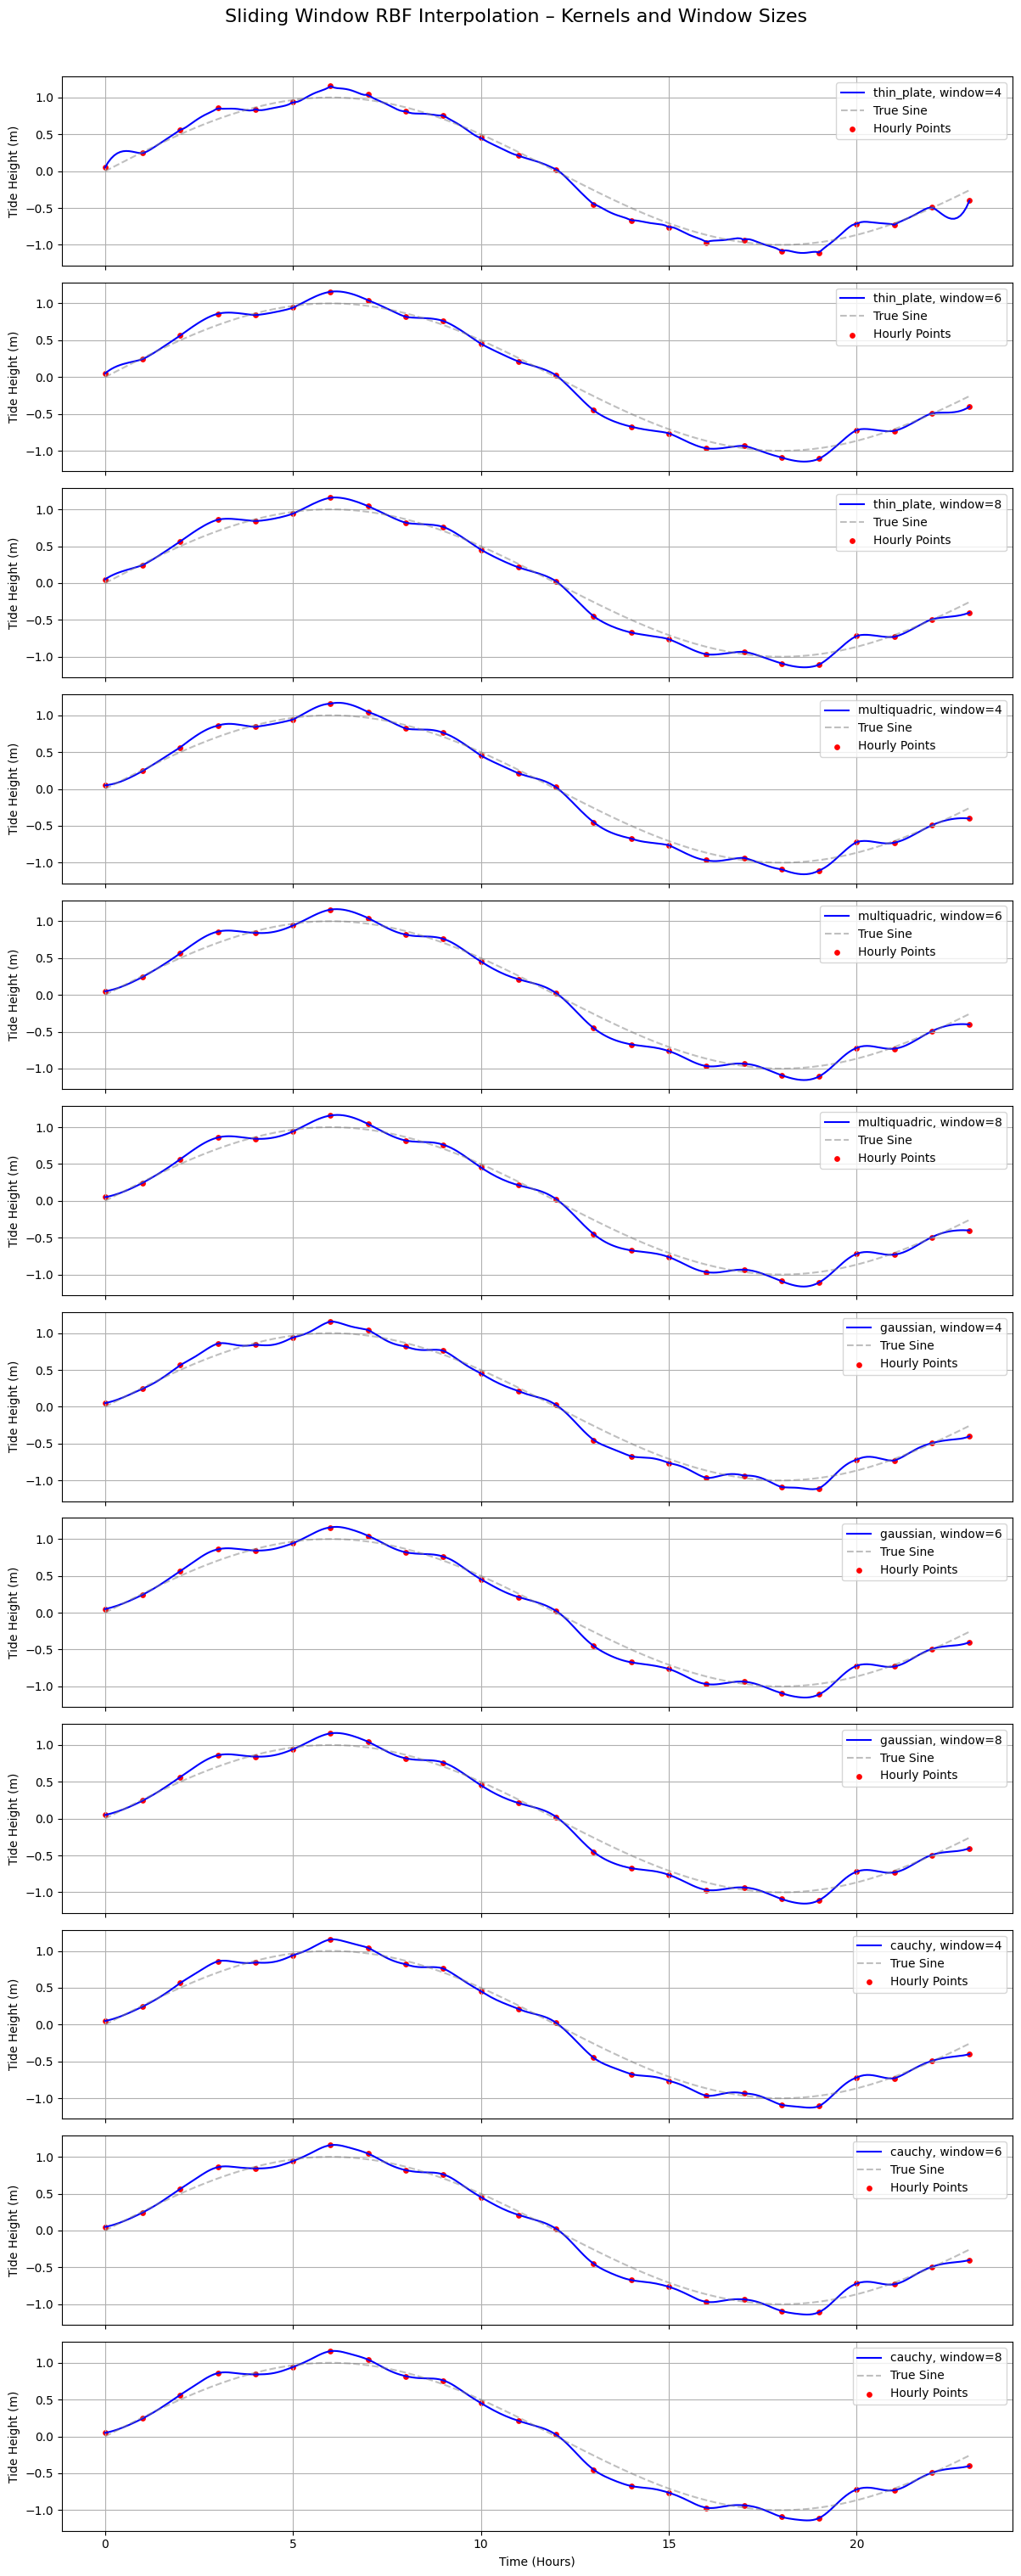

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

# ===============================
# Simulate hourly tide data
np.random.seed(42)
x_hourly = np.arange(24)  # 24 hours
y_hourly = np.sin(x_hourly * 2 * np.pi / 24) + 0.1 * np.random.randn(24)  # Tidal + noise

# Dense 5-minute resolution
x_dense = np.linspace(x_hourly.min(), x_hourly.max(), len(x_hourly) * 12)
y_true = np.sin(x_dense * 2 * np.pi / 24)

# ===============================
# Define kernels
kernel_functions = {
    'thin_plate': 'thin_plate',
    'multiquadric': 'multiquadric',
    'gaussian': 'gaussian',
    'cauchy': lambda r: 1 / (1 + r**2)
}

# ===============================
# Sliding Window Interpolation
def rbf_sliding_interpolation(x_known, y_known, x_interp, window, kernel_func):
    y_out = np.zeros_like(x_interp)
    for i, xi in enumerate(x_interp):
        idx = np.argsort(np.abs(x_known - xi))[:window]
        x_win = x_known[idx]
        y_win = y_known[idx]
        try:
            rbf = Rbf(x_win, y_win, function=kernel_func)
            y_out[i] = rbf(xi)
        except:
            y_out[i] = np.nan
    return y_out

# ===============================
# Generate plots
total_plots = len(kernel_functions) * 3
fig, axs = plt.subplots(total_plots, 1, figsize=(12, total_plots * 2.5), sharex=True, sharey=True)

plot_idx = 0
for kernel_name, kernel_func in kernel_functions.items():
    for window_size in [4, 6, 8]:
        y_interp = rbf_sliding_interpolation(x_hourly, y_hourly, x_dense, window=window_size, kernel_func=kernel_func)

        ax = axs[plot_idx]
        ax.plot(x_dense, y_interp, label=f'{kernel_name}, window={window_size}', color='blue')
        ax.plot(x_dense, y_true, '--', color='gray', label='True Sine', alpha=0.5)
        ax.scatter(x_hourly, y_hourly, color='red', s=15, label='Hourly Points')
        ax.grid(True)
        ax.legend(loc='upper right')
        ax.set_ylabel('Tide Height (m)')
        plot_idx += 1

axs[-1].set_xlabel('Time (Hours)')
plt.suptitle('Sliding Window RBF Interpolation – Kernels and Window Sizes', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()


# Real World data Exploration

                     RMSE   Log MSE
thin_plate_w4    0.093136 -4.747392
thin_plate_w6    0.091102 -4.791547
thin_plate_w8    0.089270 -4.832181
multiquadric_w4  0.091951 -4.773002
multiquadric_w6  0.090193 -4.811599
multiquadric_w8  0.091418 -4.784625
gaussian_w4      0.083597 -4.963484
gaussian_w6      0.090523 -4.804303
gaussian_w8      0.090300 -4.809241
cauchy_w4        0.085430 -4.920125
cauchy_w6        0.088085 -4.858895
cauchy_w8        0.087709 -4.867455


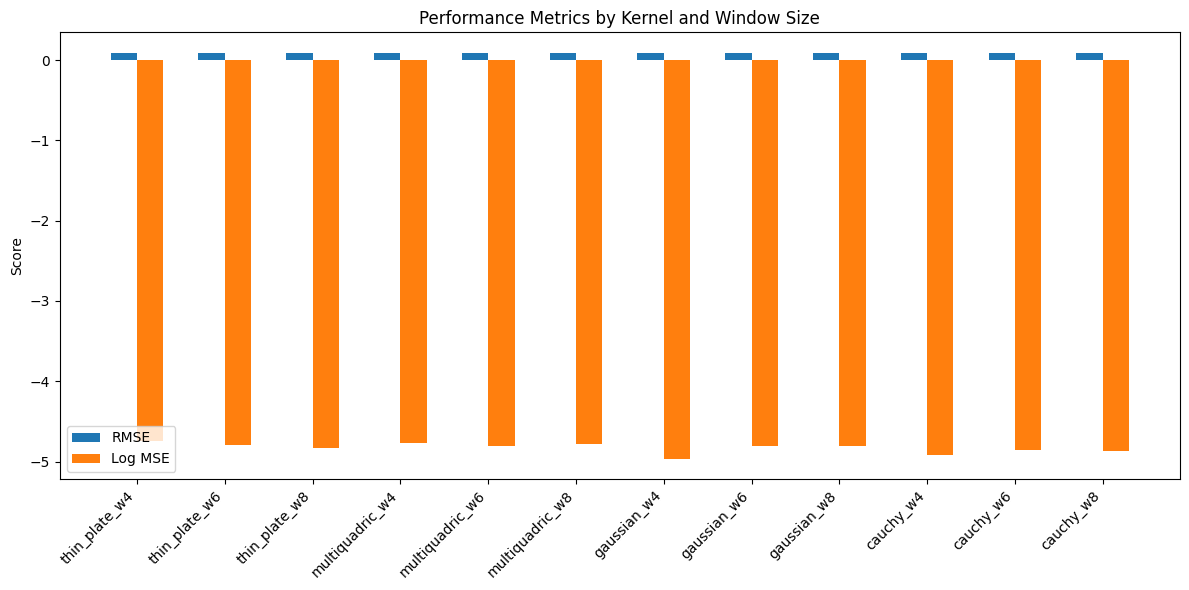

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
import pandas as pd

# ===============================
# Simulate hourly tide data
np.random.seed(42)
x_hourly = np.arange(24)  # 24 hours
y_hourly = np.sin(x_hourly * 2 * np.pi / 24) + 0.1 * np.random.randn(24)  # Tidal + noise

# Dense 5-minute resolution
x_dense = np.linspace(x_hourly.min(), x_hourly.max(), len(x_hourly) * 12)
y_true = np.sin(x_dense * 2 * np.pi / 24)

# ===============================
# Define kernels
kernel_functions = {
    'thin_plate': 'thin_plate',
    'multiquadric': 'multiquadric',
    'gaussian': 'gaussian',
    'cauchy': lambda r: 1 / (1 + r**2)
}

# ===============================
# Sliding Window Interpolation
def rbf_sliding_interpolation(x_known, y_known, x_interp, window, kernel_func):
    y_out = np.zeros_like(x_interp)
    for i, xi in enumerate(x_interp):
        idx = np.argsort(np.abs(x_known - xi))[:window]
        x_win = x_known[idx]
        y_win = y_known[idx]
        try:
            rbf = Rbf(x_win, y_win, function=kernel_func)
            y_out[i] = rbf(xi)
        except:
            y_out[i] = np.nan
    return y_out

# ===============================
# Compute metrics
labels = []
rmse_scores = []
log_mse_scores = []

for kernel_name, kernel_func in kernel_functions.items():
    for window_size in [4, 6, 8]:
        y_interp = rbf_sliding_interpolation(x_hourly, y_hourly, x_dense, window_size, kernel_func)
        mask = ~np.isnan(y_interp)
        mse = np.mean((y_interp[mask] - y_true[mask])**2)
        rmse = np.sqrt(mse)
        log_mse = np.log(mse + 1e-10)
        labels.append(f"{kernel_name}_w{window_size}")
        rmse_scores.append(rmse)
        log_mse_scores.append(log_mse)

# Create DataFrame of results
df = pd.DataFrame({
    'RMSE': rmse_scores,
    'Log MSE': log_mse_scores
}, index=labels)

print(df)

# ===============================
# Plot column (bar) chart of the scores
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(labels))
width = 0.30

ax.bar(x - width/2, df['RMSE'], width, label='RMSE')
ax.bar(x + width/2, df['Log MSE'], width, label='Log MSE')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Kernel and Window Size')
ax.legend()
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf

# ===============================
# Simulate hourly tide data
np.random.seed(42)
x_hourly = np.arange(24)
y_hourly = np.sin(x_hourly * 2 * np.pi / 24) + 0.1 * np.random.randn(24)

# Dense 5-minute resolution
x_dense = np.linspace(x_hourly.min(), x_hourly.max(), len(x_hourly) * 12)
y_true = np.sin(x_dense * 2 * np.pi / 24)

# Define kernels
kernel_functions = {
    'thin_plate': 'thin_plate',
    'multiquadric': 'multiquadric',
    'gaussian': 'gaussian',
    'cauchy': lambda r: 1 / (1 + r**2)
}

# Sliding Window Interpolation
def rbf_sliding_interpolation(x_known, y_known, x_interp, window, kernel_func):
    y_out = np.zeros_like(x_interp)
    for i, xi in enumerate(x_interp):
        idx = np.argsort(np.abs(x_known - xi))[:window]
        y_out[i] = Rbf(x_known[idx], y_known[idx], function=kernel_func)(xi)
    return y_out

# Compute metrics
results = []
for kernel_name, kernel_func in kernel_functions.items():
    for window_size in [4, 6, 8]:
        y_interp = rbf_sliding_interpolation(x_hourly, y_hourly, x_dense, window_size, kernel_func)
        mask = ~np.isnan(y_interp)
        mse = np.mean((y_interp[mask] - y_true[mask])**2)
        rmse = np.sqrt(mse)
        log_mse = np.log(mse + 1e-10)
        combined = rmse * (-log_mse)
        results.append({
            'Kernel': kernel_name,
            'Window': window_size,
            'RMSE': rmse,
            'Log MSE': log_mse,
            'Combined Score': combined
        })

df = pd.DataFrame(results)
df_sorted = df.sort_values('Combined Score')

print(df_sorted)



          Kernel  Window      RMSE   Log MSE  Combined Score
6       gaussian       4  0.083597 -4.963484        0.414935
9         cauchy       4  0.085430 -4.920125        0.420324
11        cauchy       8  0.087709 -4.867455        0.426921
10        cauchy       6  0.088085 -4.858895        0.427998
2     thin_plate       8  0.089270 -4.832181        0.431369
4   multiquadric       6  0.090193 -4.811599        0.433974
8       gaussian       8  0.090300 -4.809241        0.434273
7       gaussian       6  0.090523 -4.804303        0.434900
1     thin_plate       6  0.091102 -4.791547        0.436520
5   multiquadric       8  0.091418 -4.784625        0.437401
3   multiquadric       4  0.091951 -4.773002        0.438882
0     thin_plate       4  0.093136 -4.747392        0.442152


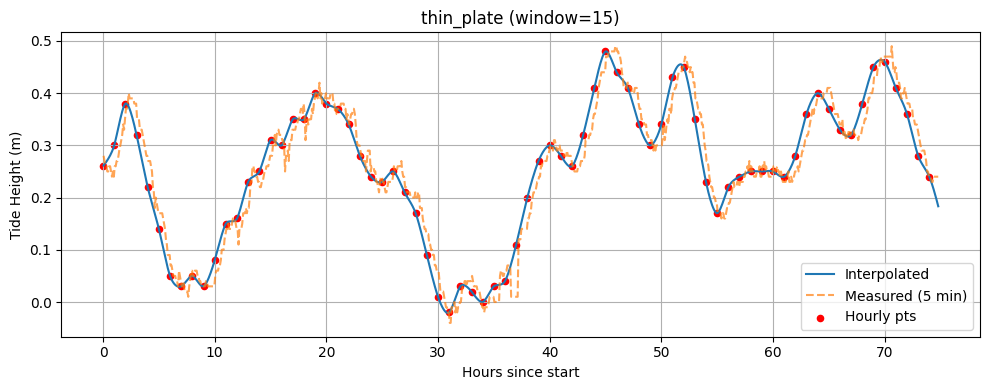

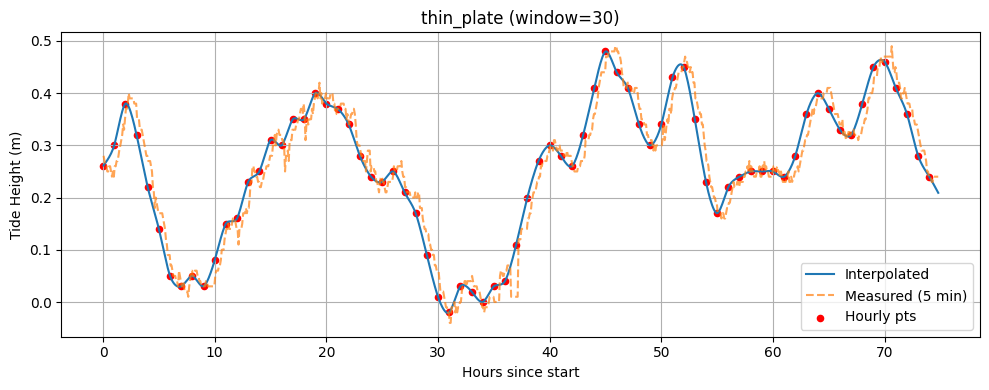

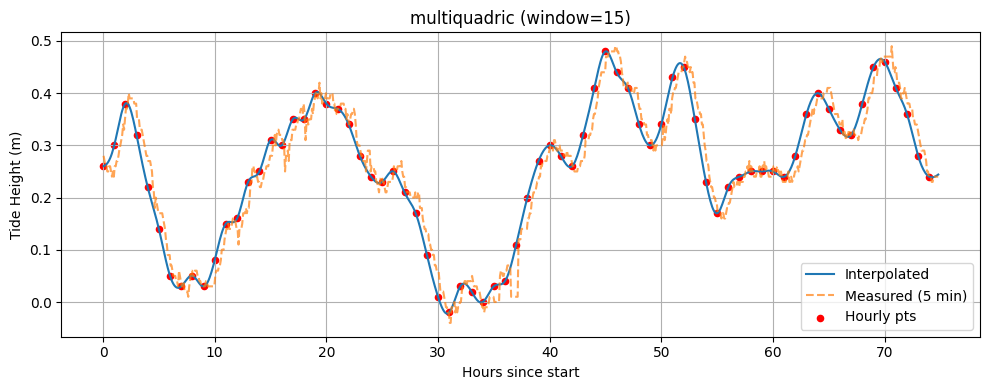

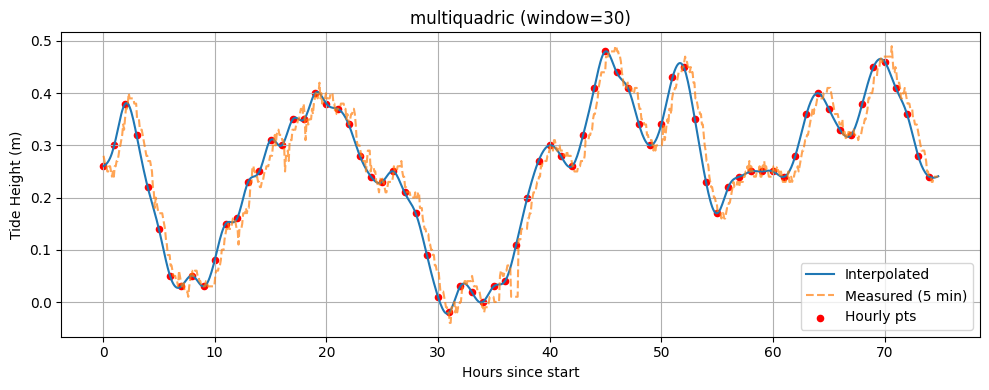

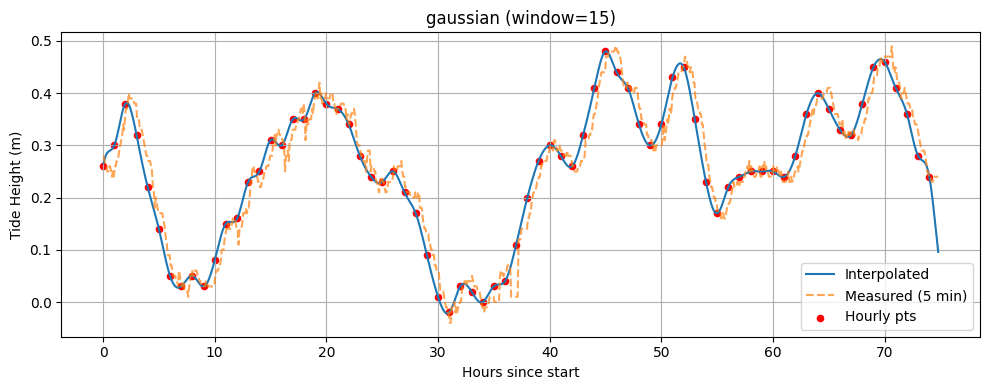

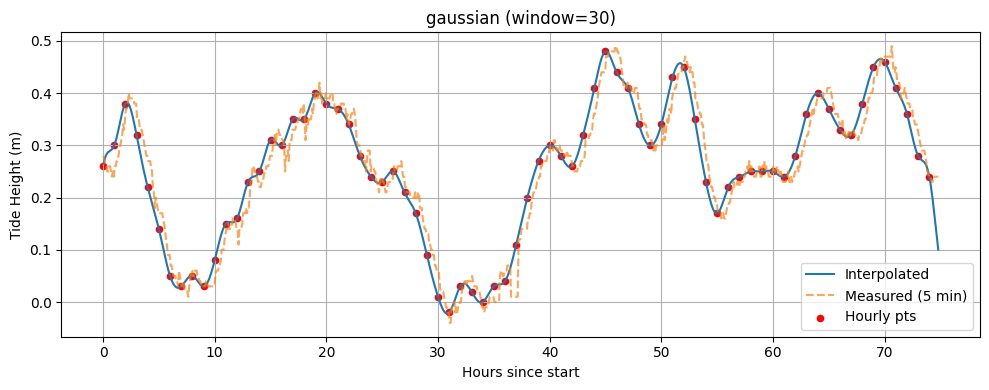

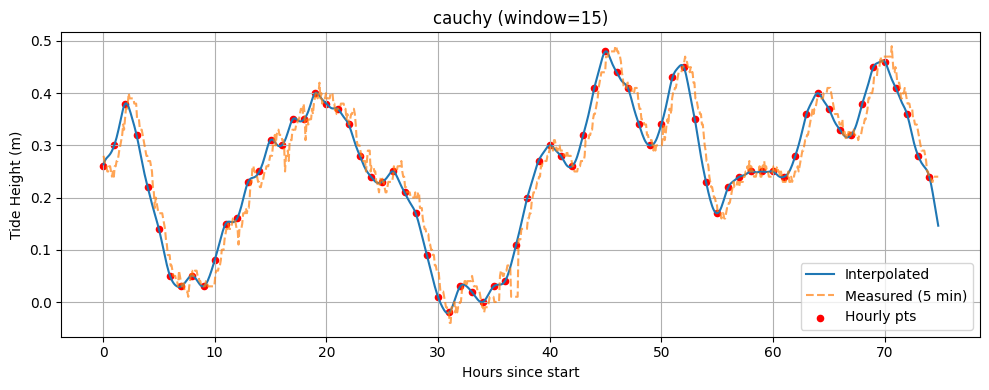

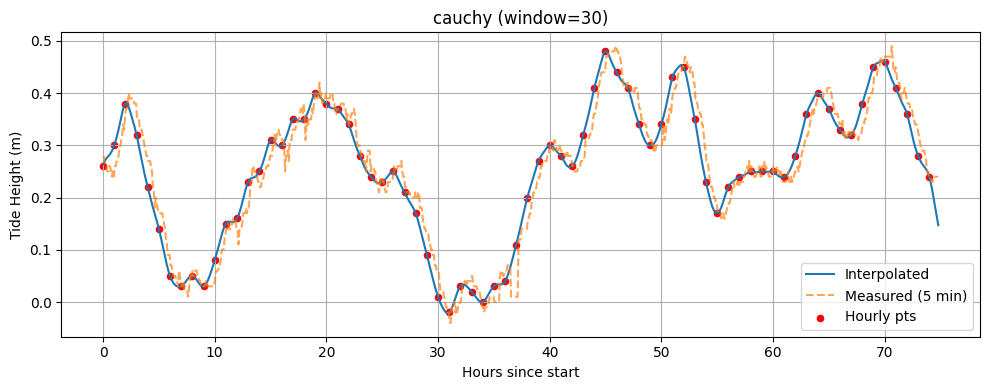

      Kernel  Window     RMSE   Log MSE  Combined Score
  thin_plate      30 0.030834 -6.958288        0.214550
multiquadric      15 0.030920 -6.952712        0.214977
multiquadric      30 0.030921 -6.952653        0.214981
multiquadric       8 0.030933 -6.951839        0.215044
  thin_plate      15 0.030950 -6.950776        0.215125
      cauchy      30 0.031334 -6.926108        0.217022
      cauchy      15 0.031346 -6.925366        0.217079
      cauchy       8 0.031362 -6.924337        0.217159
    gaussian      30 0.032057 -6.880454        0.220569
  thin_plate       8 0.032133 -6.875769        0.220936
    gaussian      15 0.032135 -6.875648        0.220946
    gaussian       8 0.032255 -6.868160        0.221533


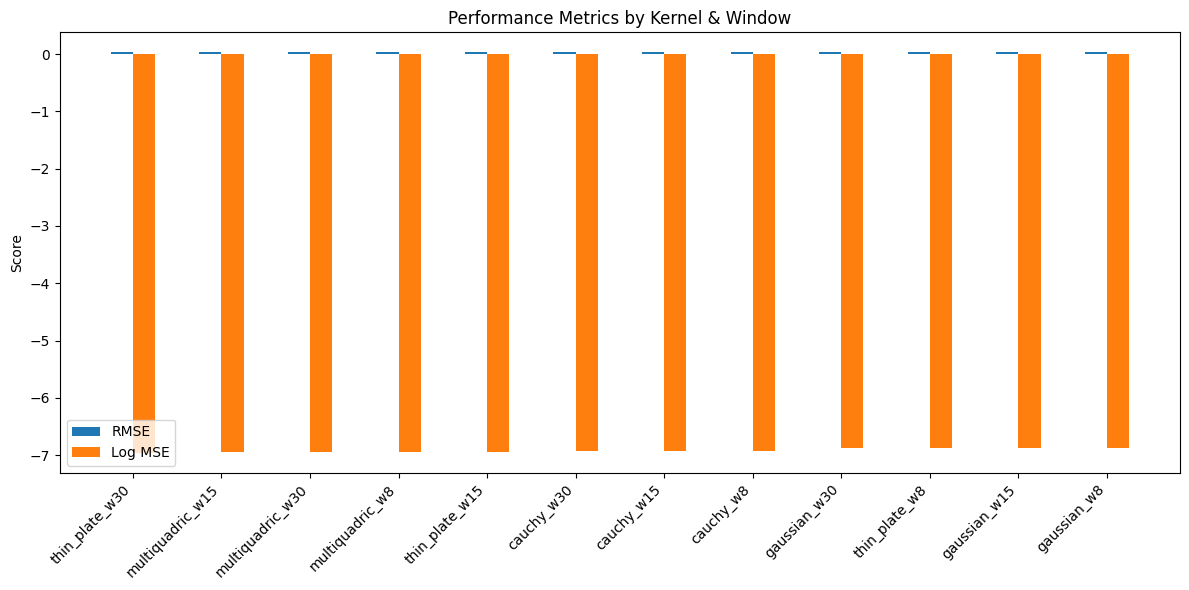

In [4]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# ===============================
# 1) Load your CSVs (Colab paths)
df_hour = pd.read_csv(
    '/content/Test interpolacoes - hour.csv',
    sep=None, engine='python',
    parse_dates=['data_hora']
)
df_5min = pd.read_csv(
    '/content/Test interpolacoes - 5min.csv',
    sep=None, engine='python',
    parse_dates=['data_hora_5min']
)

# 2) Rename for consistency & force true datetime
df_hour = df_hour.rename(columns={
    'data_hora': 'datetime',
    'Altura medida': 'y_hourly',
    'intensidade_corr_3m': 'i_hourly'
})
df_5min = df_5min.rename(columns={
    'data_hora_5min': 'datetime',
    'Altura medida': 'y_true',
    'intensidade_corr_3m': 'i_5min'
})
df_hour['datetime']  = pd.to_datetime(df_hour['datetime'],  dayfirst=True)
df_5min['datetime'] = pd.to_datetime(df_5min['datetime'], dayfirst=True)

# 3) Create numeric x-axis (hours since first timestamp)
t0 = df_hour['datetime'].min()
df_hour['x']   = (df_hour['datetime']  - t0).dt.total_seconds() / 3600
df_5min['x']   = (df_5min['datetime'] - t0).dt.total_seconds() / 3600

# 4) Extract arrays
x_known  = df_hour['x'].values
y_known  = df_hour['y_hourly'].values
x_interp = df_5min['x'].values
y_true   = df_5min['y_true'].values

# 5) Define kernels
kernel_functions = {
    'thin_plate':   'thin_plate',
    'multiquadric':'multiquadric',
    'gaussian':     'gaussian',
    'cauchy':       lambda r: 1/(1+r**2)
}

# 6) Sliding-window RBF interpolation
def rbf_sliding_interpolation(xk, yk, xi, window, kernel_func):
    yi = np.zeros_like(xi)
    for idx_pt, xv in enumerate(xi):
        neighbours = np.argsort(np.abs(xk - xv))[:window]
        yi[idx_pt] = Rbf(xk[neighbours], yk[neighbours], function=kernel_func)(xv)
    return yi

# 7) Plot individual kernel+window interpolations
for kernel_name, kernel_func in kernel_functions.items():
    for window_size in (15,30):
        y_interp = rbf_sliding_interpolation(x_known, y_known, x_interp, window_size, kernel_func)
        plt.figure(figsize=(10, 4))
        plt.plot(x_interp,    y_interp, linestyle='-', label='Interpolated')
        plt.plot(x_interp,    y_true,   linestyle='--', label='Measured (5 min)', alpha=0.7)
        plt.scatter(x_known,  y_known,  s=20, color='red',  label='Hourly pts')
        plt.title(f'{kernel_name} (window={window_size})')
        plt.xlabel('Hours since start')
        plt.ylabel('Tide Height (m)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# 8) Compute RMSE, Log-MSE & Combined Score
results = []
for name, func in kernel_functions.items():
    for w in (8,15,30):
        y_pred = rbf_sliding_interpolation(x_known, y_known, x_interp, w, func)
        mask   = ~np.isnan(y_pred)
        mse    = np.mean((y_pred[mask] - y_true[mask])**2)
        rmse   = np.sqrt(mse)
        logmse = np.log(mse + 1e-10)
        combined = rmse * (-logmse)
        results.append({
            'Kernel':         name,
            'Window':         w,
            'RMSE':           rmse,
            'Log MSE':        logmse,
            'Combined Score': combined
        })

df_results = pd.DataFrame(results).sort_values('Combined Score')
print(df_results.to_string(index=False))

# 9) Grouped bar chart of RMSE vs Log-MSE
labels = [f"{row.Kernel}_w{row.Window}" for _, row in df_results.iterrows()]
x      = np.arange(len(labels))
width  = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, df_results['RMSE'],    width, label='RMSE')
ax.bar(x + width/2, df_results['Log MSE'], width, label='Log MSE')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Kernel & Window')
ax.legend()
plt.tight_layout()
plt.show()


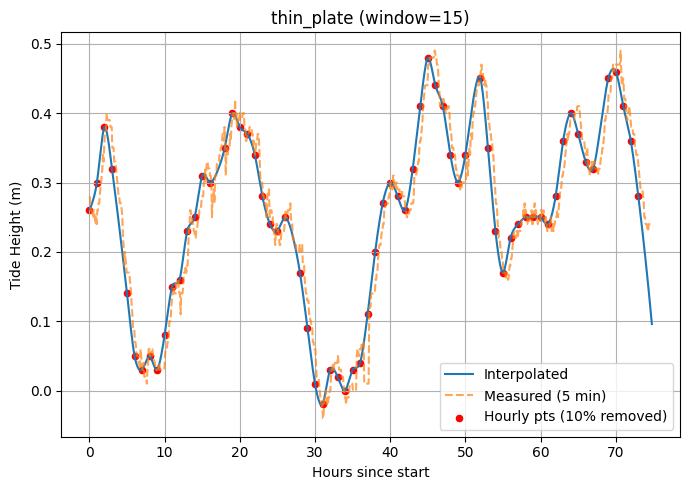

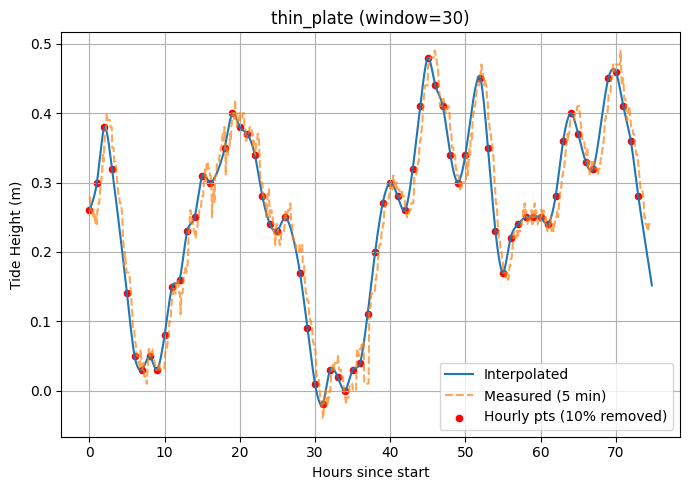

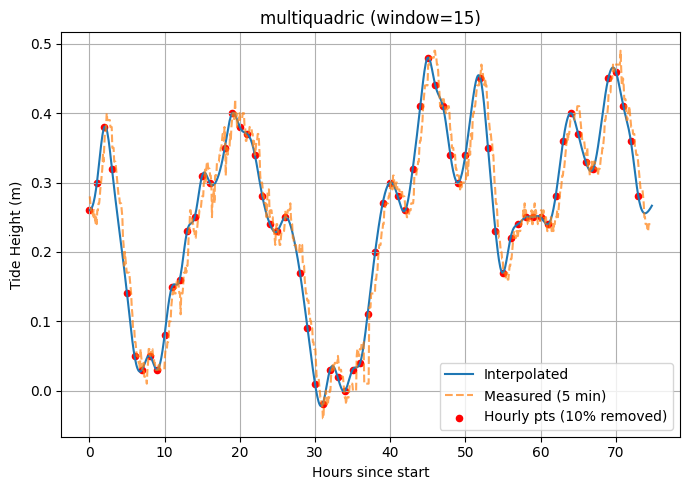

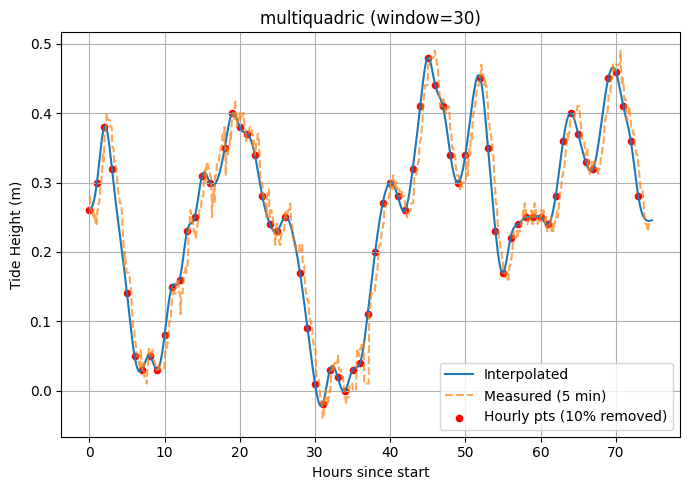

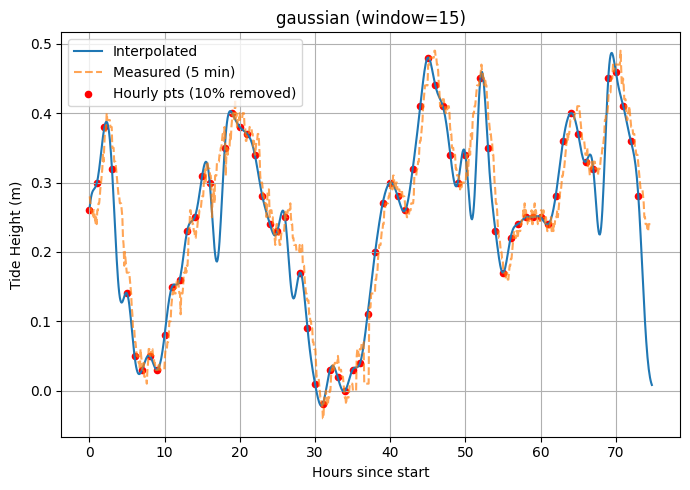

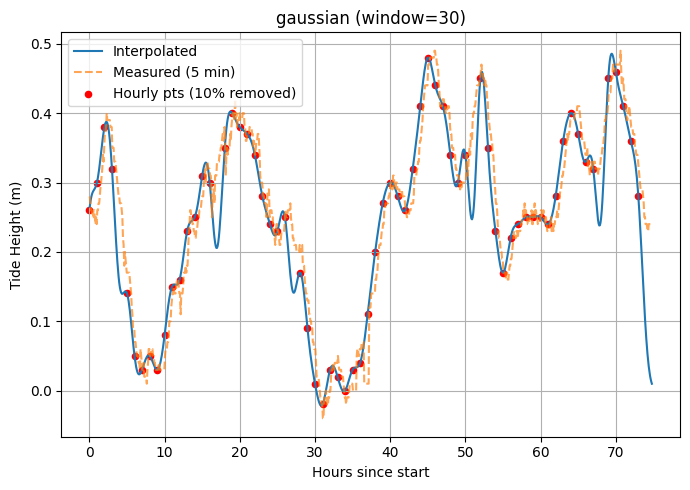

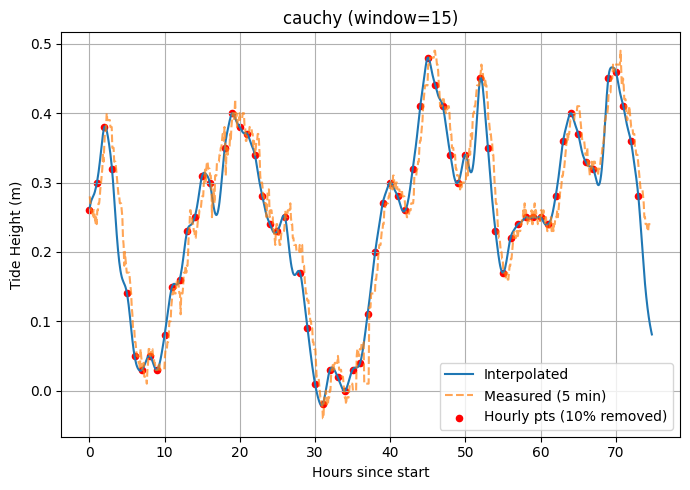

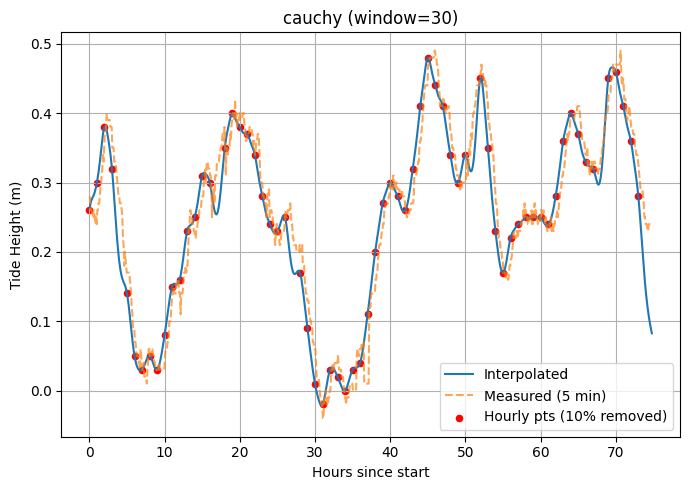

      Kernel  Window     RMSE   Log MSE  Combined Score
multiquadric      30 0.030345 -6.990231        0.212120
multiquadric      15 0.030403 -6.986406        0.212410
multiquadric       8 0.030906 -6.953595        0.214909
  thin_plate      30 0.030939 -6.951453        0.215073
  thin_plate      15 0.032322 -6.864009        0.221859
      cauchy      30 0.036629 -6.613821        0.242259
      cauchy      15 0.036808 -6.604079        0.243083
      cauchy       8 0.037071 -6.589859        0.244290
  thin_plate       8 0.041209 -6.378210        0.262838
    gaussian      30 0.046690 -6.128429        0.286139
    gaussian      15 0.048569 -6.049534        0.293821
    gaussian       8 0.048682 -6.044889        0.294278


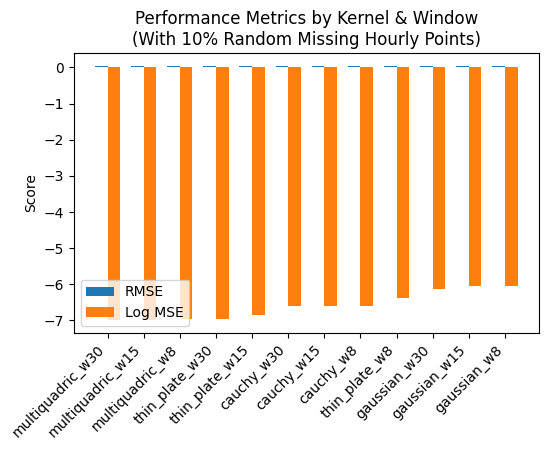

In [19]:
import numpy as np
import pandas as pd
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# ===============================
# 1) Load your CSVs (Colab paths)
df_hour = pd.read_csv(
    '/content/Test interpolacoes - hour.csv',
    sep=None, engine='python',
    parse_dates=['data_hora']
)
df_5min = pd.read_csv(
    '/content/Test interpolacoes - 5min.csv',
    sep=None, engine='python',
    parse_dates=['data_hora_5min']
)

# 2) Rename for consistency & force true datetime
df_hour = df_hour.rename(columns={
    'data_hora': 'datetime',
    'Altura medida': 'y_hourly',
    'intensidade_corr_3m': 'i_hourly'
})
df_5min = df_5min.rename(columns={
    'data_hora_5min': 'datetime',
    'Altura medida': 'y_true',
    'intensidade_corr_3m': 'i_5min'
})
df_hour['datetime']  = pd.to_datetime(df_hour['datetime'],  dayfirst=True)
df_5min['datetime'] = pd.to_datetime(df_5min['datetime'], dayfirst=True)

# 3) Create numeric x-axis (hours since first timestamp)
t0 = df_hour['datetime'].min()
df_hour['x']   = (df_hour['datetime']  - t0).dt.total_seconds() / 3600
df_5min['x']   = (df_5min['datetime'] - t0).dt.total_seconds() / 3600

# 4) Extract arrays
x_known  = df_hour['x'].values
y_known  = df_hour['y_hourly'].values
x_interp = df_5min['x'].values
y_true   = df_5min['y_true'].values

# 4.5) Simulate random missing hourly data (P_missing = 0.1)
P_missing = 0.10
rng = np.random.default_rng(42)
mask = rng.random(len(x_known)) > P_missing
x_known = x_known[mask]
y_known = y_known[mask]

# 5) Define kernels
kernel_functions = {
    'thin_plate':   'thin_plate',
    'multiquadric':'multiquadric',
    'gaussian':     'gaussian',
    'cauchy':       lambda r: 1/(1+r**2)
}

# 6) Sliding-window RBF interpolation
def rbf_sliding_interpolation(xk, yk, xi, window, kernel_func):
    yi = np.zeros_like(xi)
    for idx_pt, xv in enumerate(xi):
        neighbors = np.argsort(np.abs(xk - xv))[:window]
        yi[idx_pt] = Rbf(xk[neighbors], yk[neighbors], function=kernel_func)(xv)
    return yi

# 7) Plot individual kernel+window interpolations
for kernel_name, kernel_func in kernel_functions.items():
    for window_size in (15, 30):
        y_interp = rbf_sliding_interpolation(x_known, y_known, x_interp, window_size, kernel_func)
        plt.figure(figsize=(7, 5))
        plt.plot(x_interp, y_interp, linestyle='-', label='Interpolated')
        plt.plot(x_interp, y_true,   linestyle='--', label='Measured (5 min)', alpha=0.7)
        plt.scatter(x_known, y_known, s=20, color='red', label='Hourly pts (10% removed)')
        plt.title(f'{kernel_name} (window={window_size})')
        plt.xlabel('Hours since start')
        plt.ylabel('Tide Height (m)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# 8) Compute RMSE, Log-MSE & Combined Score
results = []
for name, func in kernel_functions.items():
    for w in (8, 15, 30):
        y_pred = rbf_sliding_interpolation(x_known, y_known, x_interp, w, func)
        mask_valid = ~np.isnan(y_pred)
        mse    = np.mean((y_pred[mask_valid] - y_true[mask_valid])**2)
        rmse   = np.sqrt(mse)
        logmse = np.log(mse + 1e-10)
        combined = rmse * (-logmse)
        results.append({
            'Kernel':         name,
            'Window':         w,
            'RMSE':           rmse,
            'Log MSE':        logmse,
            'Combined Score': combined
        })

df_results = pd.DataFrame(results).sort_values('Combined Score')
print(df_results.to_string(index=False))

# 9) Grouped bar chart of RMSE vs Log-MSE
labels = [f"{row.Kernel}_w{row.Window}" for _, row in df_results.iterrows()]
x      = np.arange(len(labels))
width  = 0.35

fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(x - width/2, df_results['RMSE'],    width, label='RMSE')
ax.bar(x + width/2, df_results['Log MSE'], width, label='Log MSE')

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Kernel & Window\n(With 10% Random Missing Hourly Points)')
ax.legend()

# Remove tight_layout e ajusta manualmente
plt.subplots_adjust(top=0.85, bottom=0.25)  # Mais espaço no topo e no rodapé

ax.set_aspect('equal', adjustable='box')

plt.show()


# Optimizing the Kernel

Best KRR params: {'alpha': np.float64(0.01), 'gamma': np.float64(0.01)}
Test RMSE: 0.0478
Test Log MSE: -6.0802
Combined Score: 0.2908


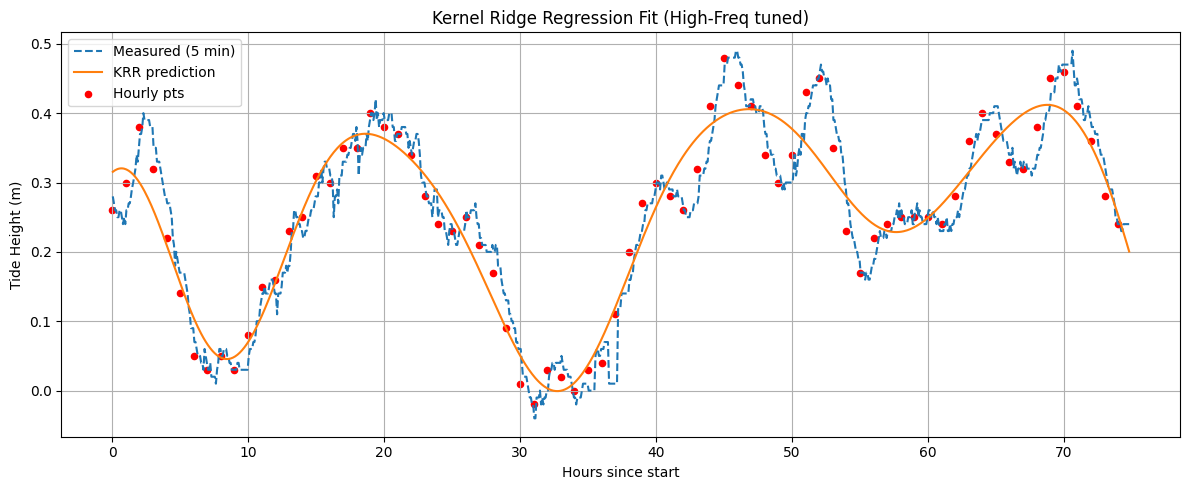

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# ===============================
# 1) Load your CSVs
df_hour = pd.read_csv(
    '/content/Test interpolacoes - hour.csv',
    engine='python', sep=None,
    parse_dates=['data_hora']
)
df_5min = pd.read_csv(
    '/content/Test interpolacoes - 5min.csv',
    engine='python', sep=None,
    parse_dates=['data_hora_5min']
)

# 2) Rename & parse dates
df_hour = df_hour.rename(columns={
    'data_hora': 'datetime',
    'Altura medida': 'y_hourly',
    'intensidade_corr_3m': 'i_hourly'
})
df_5min = df_5min.rename(columns={
    'data_hora_5min': 'datetime',
    'Altura medida': 'y_true',
    'intensidade_corr_3m': 'i_5min'
})
df_hour['datetime']  = pd.to_datetime(df_hour['datetime'],  dayfirst=True)
df_5min['datetime'] = pd.to_datetime(df_5min['datetime'], dayfirst=True)

# 3) Create numeric feature (hours since start)
t0 = df_hour['datetime'].min()
df_hour['x']   = (df_hour['datetime']  - t0).dt.total_seconds() / 3600
df_5min['x']   = (df_5min['datetime'] - t0).dt.total_seconds() / 3600

X_train = df_hour['x'].values.reshape(-1,1)
y_train = df_hour['y_hourly'].values
X_test  = df_5min['x'].values.reshape(-1,1)
y_test  = df_5min['y_true'].values

# ===============================
# 4) Kernel Ridge Regression + Grid Search
#    Expanded gamma range for sharper (high-freq) fits,
#    and smaller alpha for less smoothing
param_grid = {
    'alpha': np.logspace(-6, -1, 6),    # from 1e-6 to 1e-1
    'gamma': np.logspace(-2, 3, 6)      # from 1e-2 to 1e+3
}
tscv = TimeSeriesSplit(n_splits=5)
kr = KernelRidge(kernel='rbf')
grid = GridSearchCV(
    estimator=kr,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best KRR params:", grid.best_params_)

best_kr = grid.best_estimator_

# ===============================
# 5) Predict & compute metrics
y_pred = best_kr.predict(X_test)
mse    = mean_squared_error(y_test, y_pred)
rmse   = np.sqrt(mse)
log_mse = np.log(mse + 1e-10)
combined = rmse * (-log_mse)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test Log MSE: {log_mse:.4f}")
print(f"Combined Score: {combined:.4f}")

# ===============================
# 6) Plot comparison (now with potentially more oscillations)
plt.figure(figsize=(12,5))
plt.plot(df_5min['x'], y_test,   '--', label='Measured (5 min)')
plt.plot(df_5min['x'], y_pred,   '-',  label='KRR prediction')
plt.scatter(df_hour['x'], df_hour['y_hourly'], c='red', s=20, label='Hourly pts')
plt.xlabel('Hours since start')
plt.ylabel('Tide Height (m)')
plt.title('Kernel Ridge Regression Fit (High-Freq tuned)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
